# **1. Problem Definition**

---

## 📌 Kasus Klasifikasi: Segmentasi Nasabah Bank

#### **Latar Belakang**

Sebuah bank nasional sudah melakukan **clustering unsupervised** terhadap data transaksi nasabah. Dari hasil analisis, ditemukan **tiga segmen utama** yang mencerminkan perilaku keuangan nasabah:

1. **Cluster 1 – Middle Spender Loyalis**

   * Transaksi normal, saldo cukup stabil.
   * Cenderung loyal ke merchant & lokasi tertentu.
   * Memanfaatkan semua channel (ATM, mobile banking, cabang).

2. **Cluster 2 – Nasabah Mapan Konservatif**

   * Saldo besar, transaksi relatif kecil.
   * Mayoritas lebih tua, cenderung berhati-hati.
   * Loyal pada merchant/lokasi tertentu, lebih lambat dalam transaksi.

3. **Cluster 3 – Muda High Spender, Low Balance**

   * Jumlah transaksi tinggi, saldo relatif rendah.
   * Banyak berasal dari occupation 3 (misal: karyawan muda).
   * Loyal ke merchant/lokasi tertentu.

---

#### **Permasalahan**

* Clustering bagus untuk **menemukan pola**, tapi kurang praktis untuk **real-time assignment** nasabah baru.
* Bank butuh model **klasifikasi supervised** yang bisa **memprediksi cluster nasabah baru** berdasarkan data transaksi dan profil nasabah.

---

#### **Tujuan**

Membangun **model klasifikasi** untuk mengidentifikasi segmen nasabah:

* Input: data transaksi & profil nasabah.
* Output: label cluster (`Middle Spender Loyalis`, `Mapan Konservatif`, atau `Muda High Spender`).
* Gunanya: strategi pemasaran personalisasi, retensi nasabah, dan cross-selling produk.

---

#### **Fitur Kandidat**

* **Demografi**

  * `CustomerAge`
  * `CustomerOccupation`
* **Finansial**

  * `TransactionAmount` (rata-rata, std, total per periode)
  * `AccountBalance`
* **Perilaku transaksi**

  * `TransactionDuration`
  * `TransactionType` (encoded: debit/kredit)
  * `Channel` (encoded: mobile, ATM, cabang)
  * `LoginAttempts`
* **Preferensi merchant/lokasi**

  * `MerchantID`, `Location` (encoded frequency / top-N)
* **Temporal**

  * Selisih hari `TransactionDate` vs `PreviousTransactionDate` → frekuensi transaksi.

---

#### **Workflow Klasifikasi**

1. **Data Preparation**

   * Buat label `Cluster` (1, 2, 3) hasil clustering sebelumnya.
   * Feature engineering (contoh: frekuensi transaksi, rata-rata transaksi per akun).
   * Encoding kategorikal (`TransactionType`, `Channel`, `CustomerOccupation`, `Location`, `MerchantID`).
   * Normalisasi numerik (`TransactionAmount`, `AccountBalance`, `TransactionDuration`).

2. **Train-Test Split**

   * 70/30 atau 80/20.
   * Stratified split biar distribusi cluster tetap seimbang.

3. **Modeling**

   * Coba beberapa algoritma:

     * Random Forest → interpretabilitas baik.
     * XGBoost/LightGBM → performa tinggi.
     * Logistic Regression / SVM → baseline.
   * Hyperparameter tuning (GridSearchCV / Optuna).

4. **Evaluation**

   * Accuracy, Precision, Recall, F1-score (per cluster).
   * Confusion matrix → lihat cluster mana yang sering salah prediksi.
   * Macro F1 → penting jika cluster imbalance.

5. **Deployment**

   * Model dipakai untuk prediksi segmen nasabah baru.
   * API (Flask/FastAPI/Fiber) → input data nasabah → output cluster.

6. **Monitoring**

   * Cek performa di data baru.
   * Jika ada perubahan pola transaksi (concept drift), retrain model.

---


# **2. Import Library**

In [29]:
#Type your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency

# **3. Memuat Dataset dari Hasil Clustering**
Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [2]:
# Gunakan dataset hasil clustering yang memiliki fitur Target
# Silakan gunakan dataset data_clustering jika tidak menerapkan Interpretasi Hasil Clustering [Advanced]
# Silakan gunakan dataset data_clustering_inverse jika menerapkan Interpretasi Hasil Clustering [Advanced]
# Lengkapi kode berikut
# ___ = pd_read_csv("___.csv")
df = pd.read_csv("../data/01_raw/data_train.csv")

In [3]:
# Tampilkan 5 baris pertama dengan function head.
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,Cluster
0,TX000319,AC00106,301.85,2023-04-18 17:43:50,Debit,Columbus,D000433,55.154.161.250,M062,Online,54,Engineer,25,1,6586.19,2024-11-04 08:10:05,0
1,TX000299,AC00495,689.54,2023-03-06 16:46:57,Debit,Oklahoma City,D000395,89.6.100.149,M038,Branch,27,Student,93,1,1633.76,2024-11-04 08:08:53,2
2,TX002379,AC00150,199.02,2023-01-30 17:36:54,Debit,Memphis,D000535,98.255.160.110,M081,ATM,22,Student,185,1,793.63,2024-11-04 08:08:22,2
3,TX000446,AC00480,50.17,2023-09-18 16:57:44,Credit,Sacramento,D000549,25.188.196.47,M039,ATM,77,Retired,35,1,7752.14,2024-11-04 08:10:59,1
4,TX001903,AC00336,1168.26,2023-06-12 16:25:21,Credit,Philadelphia,D000697,111.78.64.133,M005,Online,73,Retired,37,1,1385.74,2024-11-04 08:09:53,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260 entries, 0 to 2259
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2260 non-null   object 
 1   AccountID                2260 non-null   object 
 2   TransactionAmount        2260 non-null   float64
 3   TransactionDate          2260 non-null   object 
 4   TransactionType          2260 non-null   object 
 5   Location                 2260 non-null   object 
 6   DeviceID                 2260 non-null   object 
 7   IP Address               2260 non-null   object 
 8   MerchantID               2260 non-null   object 
 9   Channel                  2260 non-null   object 
 10  CustomerAge              2260 non-null   int64  
 11  CustomerOccupation       2260 non-null   object 
 12  TransactionDuration      2260 non-null   int64  
 13  LoginAttempts            2260 non-null   int64  
 14  AccountBalance          

In [5]:
df.isnull().sum()

TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
Cluster                    0
dtype: int64

In [6]:
df.duplicated().sum()

0

# **4. EDA (Exploratory Data Analysis)**
* Cek distribusi label (apakah seimbang/unbalanced).
* Analisis fitur (numerik → rata-rata, sebaran; kategorikal → frekuensi).
* Cek missing value, outlier.
* Visualisasi (histogram, boxplot, bar chart, korelasi).

In [7]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])
df_categorical = df.select_dtypes(include=['object'])


In [8]:
df_numeric.head()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,Cluster
0,301.85,54,25,1,6586.19,0
1,689.54,27,93,1,1633.76,2
2,199.02,22,185,1,793.63,2
3,50.17,77,35,1,7752.14,1
4,1168.26,73,37,1,1385.74,2


ada dua column categorical yang terikut, seperti login attempts dan cluster, akan di analisis ketika pada saat analisis path categorical

In [9]:
df_numeric.describe()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,Cluster
count,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000,2260.000000
mean,297.722947,44.710619,120.262832,1.126991,5095.194960,1.019027
std,293.509539,17.862427,70.012583,0.607812,3893.504345,0.812742
min,0.260000,18.000000,10.000000,1.000000,101.250000,0.000000
25%,81.240000,27.000000,63.000000,1.000000,1504.370000,0.000000
50%,208.545000,45.000000,114.000000,1.000000,4717.175000,1.000000
75%,409.807500,59.000000,162.000000,1.000000,7642.602500,2.000000
max,1919.110000,80.000000,300.000000,5.000000,14977.990000,2.000000


#### 🔎 Interpretasi per Kolom

* **TransactionAmount**

  * Rata-rata transaksi: \~298
  * Minimum transaksi: 0.26 (sangat kecil)
  * Maksimum transaksi: \~1919 (cukup besar)
    → Artinya variasi transaksi sangat tinggi, ada yang kecil sekali sampai ribuan.

* **CustomerAge**

  * Rata-rata umur: \~45 tahun
  * Minimum: 18 (mungkin nasabah muda)
  * Maksimum: 80 (nasabah senior)
    → Dataset mencakup generasi muda sampai tua.

* **TransactionDuration** (lama transaksi, misal dalam detik)

  * Rata-rata: 120 detik
  * Minimum: 10 detik (cepat banget)
  * Maksimum: 300 detik (lama)

* **LoginAttempts**

  * Rata-rata: \~1.12
  * Mayoritas: 1 kali login berhasil
  * Maksimum: 5 kali → ada user yang sering gagal login.

* **AccountBalance**

  * Rata-rata saldo: \~5095
  * Minimum: 101 → saldo sangat kecil
  * Maksimum: 14977 → saldo sangat besar
  * Penyebarannya besar (std 3893), ada nasabah miskin sampai kaya.

* **Cluster** (hasil clustering → target klasifikasi)

  * Nilai: 0, 1, 2
  * Mean: \~1.0 → artinya distribusi relatif seimbang
  * Min: 0, Max: 2 → benar, ada 3 cluster.



In [10]:
df_numeric["LoginAttempts"].value_counts()

LoginAttempts
1    2148
4      30
5      29
3      28
2      25
Name: count, dtype: int64

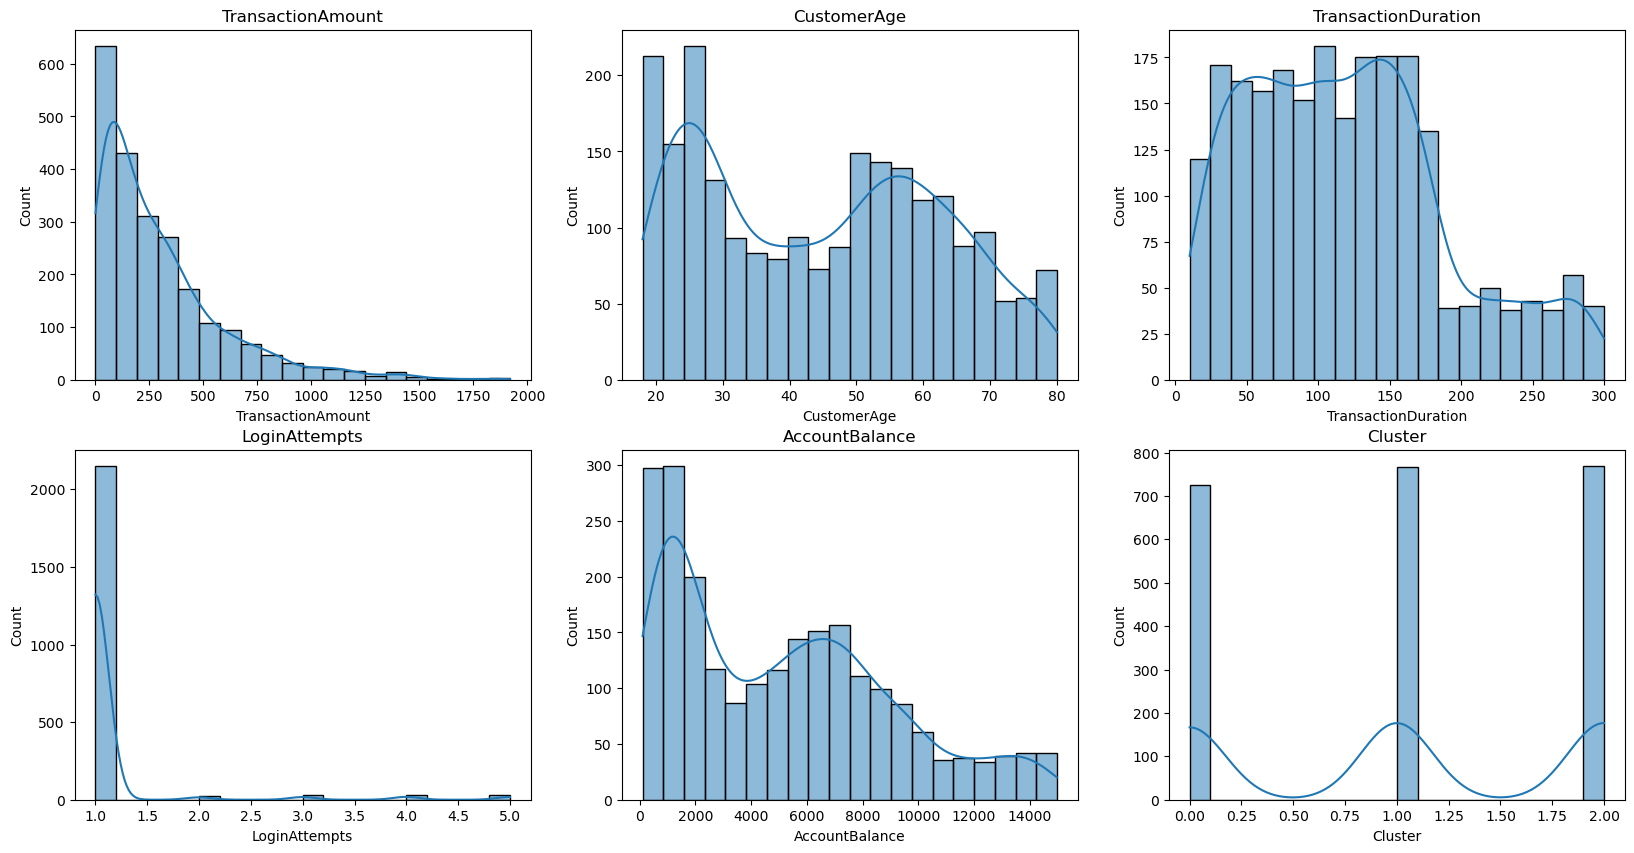

In [11]:
fig = plt.figure(figsize=(20, 10))
for i, col in enumerate(df_numeric.columns):
    ax = fig.add_subplot(2, 3, i + 1)
    sns.histplot(df_numeric[col], ax=ax, bins=20, kde=True)
    ax.set_title(col)
plt.show()

data ternyata skewwnes parah

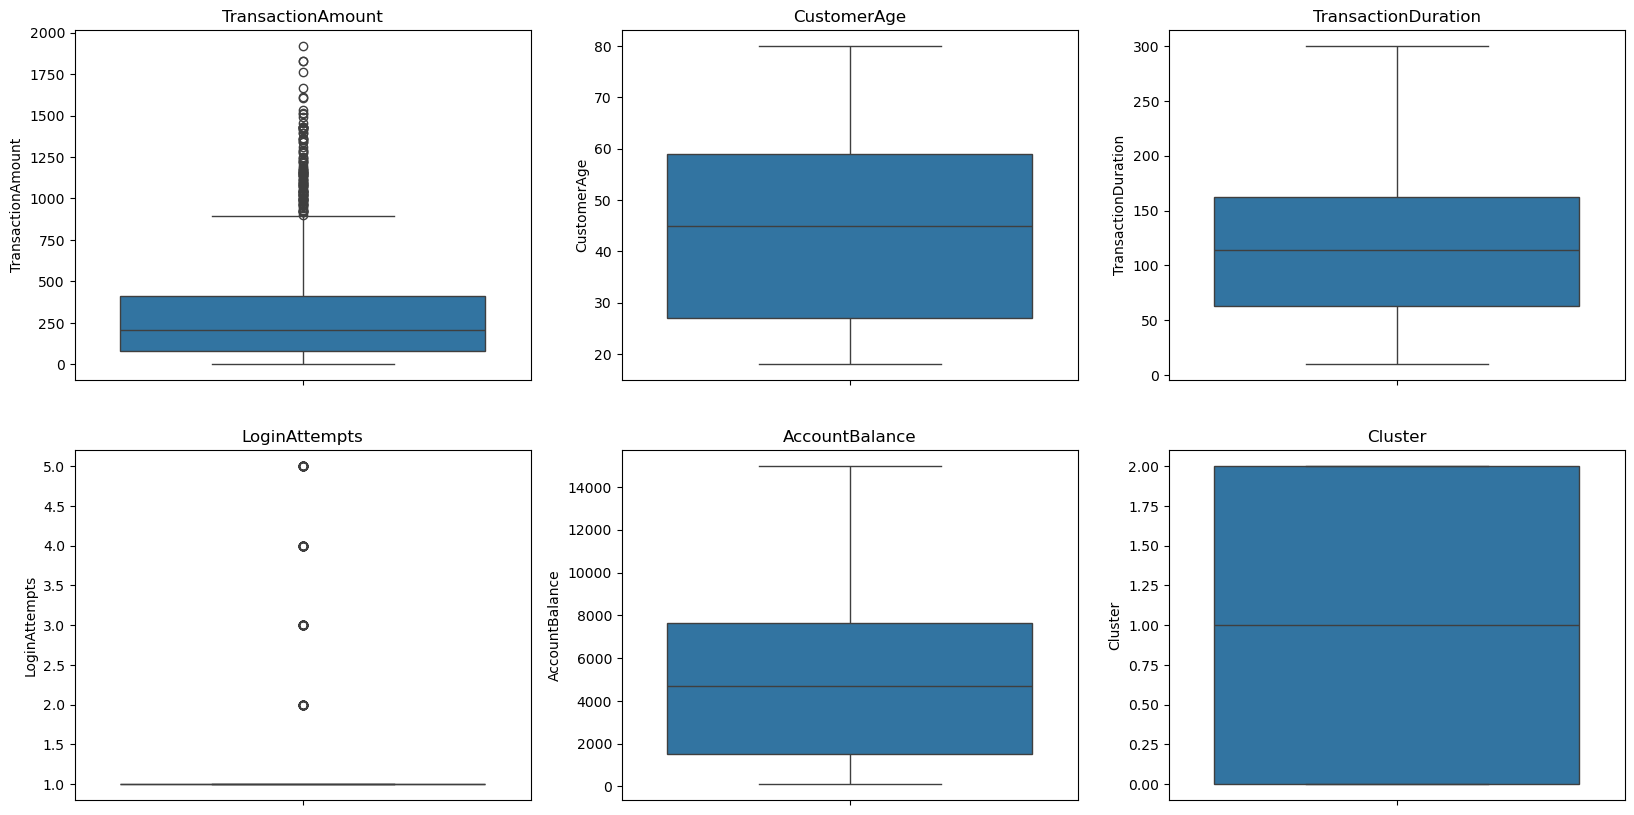

In [12]:
fig = plt.figure(figsize=(20, 10))
for i, col in enumerate(df_numeric.columns):
    ax = fig.add_subplot(2, 3, i + 1)
    sns.boxplot(df_numeric[col], ax=ax)
    ax.set_title(col)
plt.show()

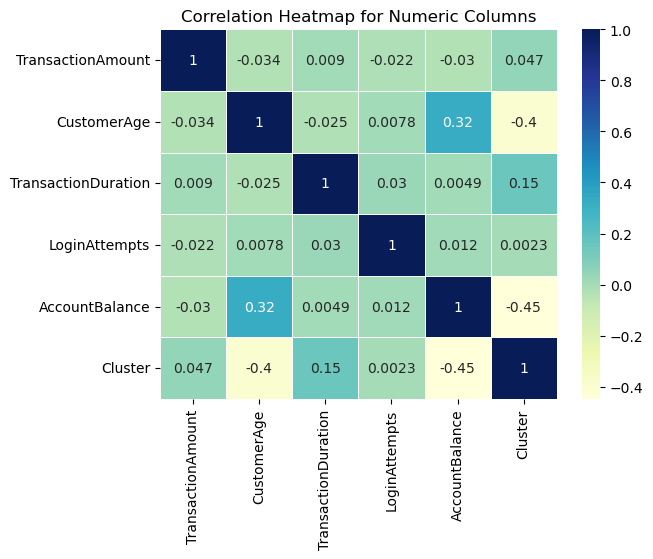

In [27]:
sns.heatmap(
    df_numeric.corr(),
    cmap="YlGnBu",
    annot=True,
    linewidths=0.5
)
plt.title("Correlation Heatmap for Numeric Columns")
plt.show()


ada satu column yang mengalami outlier

In [13]:
df_categorical.head()

,TransactionID,AccountID,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerOccupation,PreviousTransactionDate
0,TX000319,AC00106,2023-04-18 17:43:50,Debit,Columbus,D000433,55.154.161.250,M062,Online,Engineer,2024-11-04 08:10:05
1,TX000299,AC00495,2023-03-06 16:46:57,Debit,Oklahoma City,D000395,89.6.100.149,M038,Branch,Student,2024-11-04 08:08:53
2,TX002379,AC00150,2023-01-30 17:36:54,Debit,Memphis,D000535,98.255.160.110,M081,ATM,Student,2024-11-04 08:08:22
3,TX000446,AC00480,2023-09-18 16:57:44,Credit,Sacramento,D000549,25.188.196.47,M039,ATM,Retired,2024-11-04 08:10:59
4,TX001903,AC00336,2023-06-12 16:25:21,Credit,Philadelphia,D000697,111.78.64.133,M005,Online,Retired,2024-11-04 08:09:53


In [14]:
for col in df_categorical.columns:
    print(col)
    print(df_categorical[col].value_counts())
    print()

TransactionID
TransactionID
TX000319    1
TX001474    1
TX002212    1
TX000761    1
TX000111    1
           ..
TX001222    1
TX000437    1
TX002376    1
TX002130    1
TX000861    1
Name: count, Length: 2260, dtype: int64

AccountID
AccountID
AC00363    11
AC00456    11
AC00202    11
AC00362    10
AC00480    10
           ..
AC00472     1
AC00180     1
AC00486     1
AC00101     1
AC00038     1
Name: count, Length: 489, dtype: int64

TransactionDate
TransactionDate
2023-04-18 17:43:50    1
2023-04-17 16:53:29    1
2023-01-02 16:31:28    1
2023-08-07 16:54:58    1
2023-11-22 16:13:39    1
                      ..
2023-02-06 17:32:04    1
2023-01-24 16:00:14    1
2023-07-24 17:07:27    1
2023-08-02 17:52:47    1
2023-01-20 16:23:48    1
Name: count, Length: 2260, dtype: int64

TransactionType
TransactionType
Debit     1750
Credit     510
Name: count, dtype: int64

Location
Location
Philadelphia        63
Oklahoma City       63
Los Angeles         62
Fort Worth          62
Detroit         

yang ingin di analisis :
1. transaction type
2. login attemtps
3. location
4. channel
5. customer occupation

/tmp/ipykernel_13449/4169901686.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


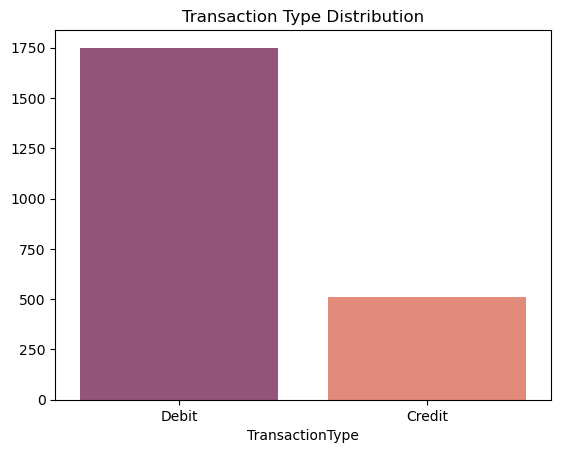

In [15]:
sns.barplot(
    x=df_categorical["TransactionType"].value_counts().index,
    y=df_categorical["TransactionType"].value_counts().values,
    palette="rocket",
    alpha=0.8
)
plt.title("Transaction Type Distribution")
plt.show()

Catatan :
1. ada dua data yang muncul di transaction type : debit dan credit
2. data unbalance = debit lebih banyak proporsi nya daripada credit
3. mungkin nanti memakai pendekatan smote over sampling untuk porposi yang seimbang

In [16]:
df_numeric["LoginAttempts"].value_counts()

LoginAttempts
1    2148
4      30
5      29
3      28
2      25
Name: count, dtype: int64

/tmp/ipykernel_13449/1606173201.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


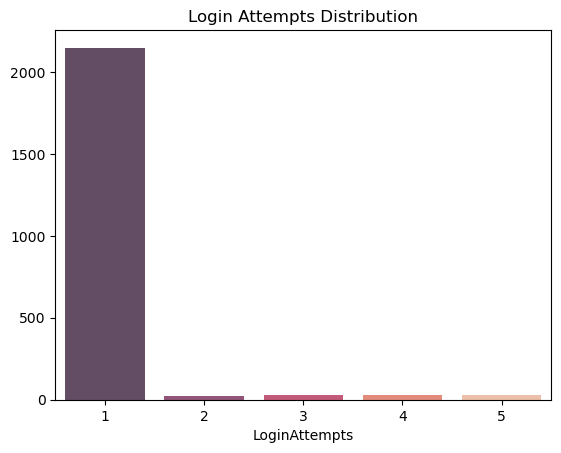

In [17]:
sns.barplot(
    x=df_numeric["LoginAttempts"].value_counts().index,
    y=df_numeric["LoginAttempts"].value_counts().values,
    palette="rocket",
    alpha=0.8
)
plt.title("Login Attempts Distribution")
plt.show()


---

### 📌 Arti **LoginAttempts**

* Ini adalah **jumlah percobaan login** sebelum sebuah transaksi berhasil dilakukan.
* **Semakin besar nilainya → semakin banyak gagal login dulu** sebelum berhasil transaksi.
* Itu bisa dianggap sebagai **indikasi anomali** atau **risiko keamanan**, karena normalnya orang login 1x langsung berhasil.

---

### 📊 Distribusi yang kamu kasih

| LoginAttempts | Jumlah transaksi | Interpretasi                                                                       |
| ------------- | ---------------- | ---------------------------------------------------------------------------------- |
| **1**         | 2148             | Hampir semua transaksi normal → user langsung berhasil login di percobaan pertama. |
| **2**         | 25               | Ada 25 transaksi di mana user butuh 2x percobaan login.                            |
| **3**         | 28               | 28 transaksi butuh 3x percobaan login.                                             |
| **4**         | 30               | 30 transaksi butuh 4x percobaan login.                                             |
| **5**         | 29               | 29 transaksi butuh 5x percobaan login → bisa jadi anomali/fraud.                   |

---

### 🔎 Insight

* **Normal**: `LoginAttempts = 1` → mayoritas (2148/2260 ≈ 95%).
* **Tidak biasa**: `LoginAttempts > 1` → hanya 112 kasus (\~5%).
* Semakin tinggi `LoginAttempts`, semakin besar kemungkinan:

  * User lupa password.
  * Ada bot/penipu yang mencoba menebak password.
  * Aktivitas mencurigakan (misal fraud detection).

---

In [18]:
# untuk column location, kita ambil aja 5 teratas
df_categorical["Location"].value_counts().sort_values(ascending=False).head()

Location
Philadelphia     63
Oklahoma City    63
Los Angeles      62
Fort Worth       62
Detroit          61
Name: count, dtype: int64

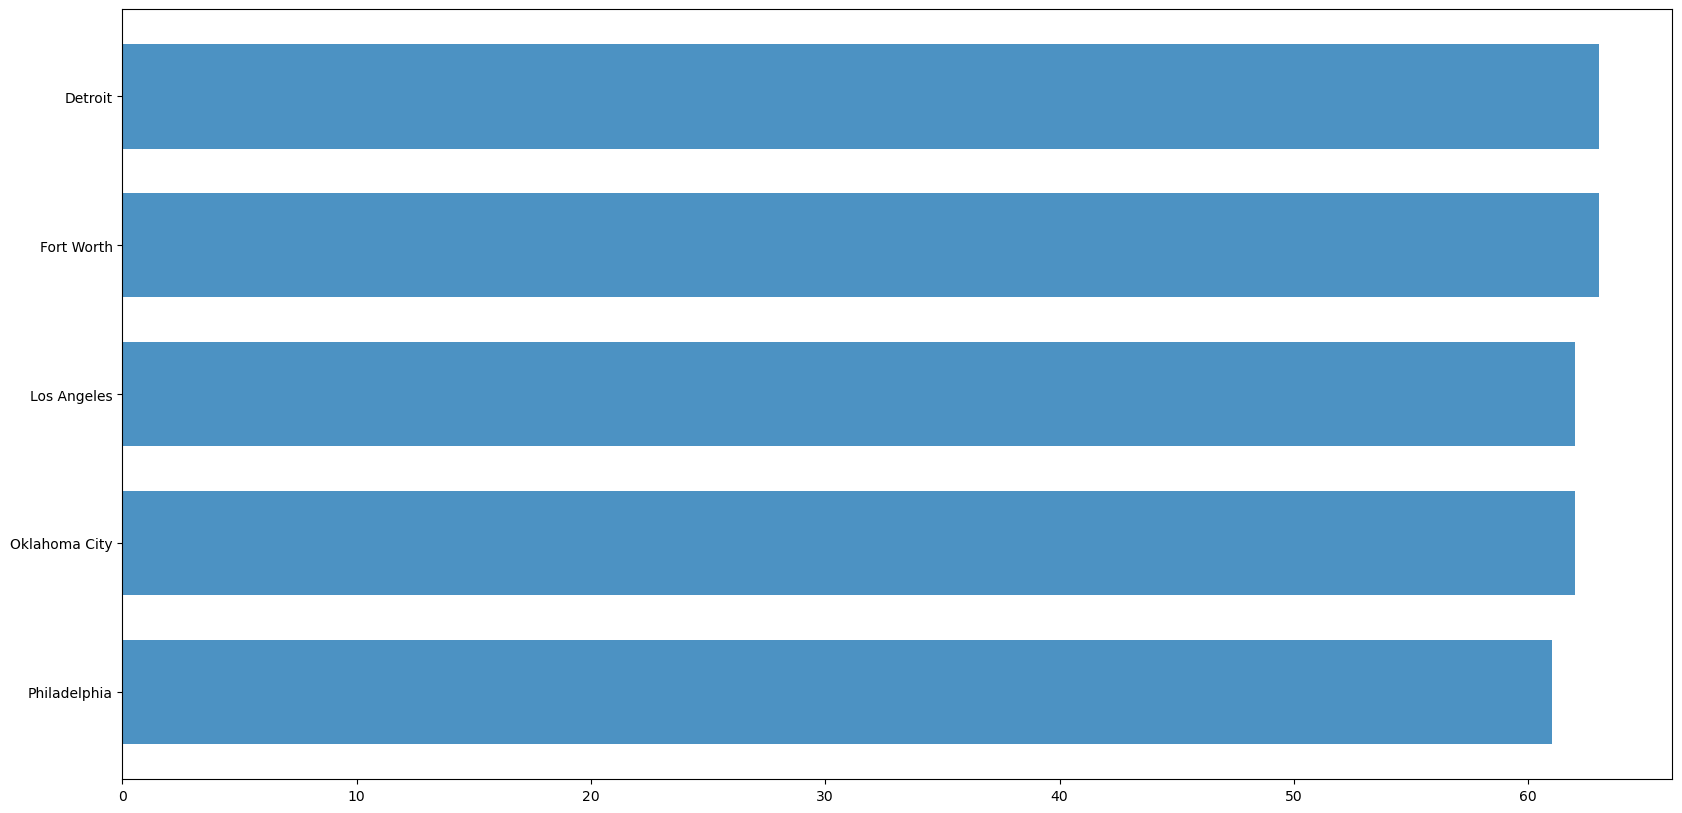

In [22]:
fig = fig = plt.figure(figsize=(20, 10))
plt.barh(
    df_categorical["Location"].value_counts().sort_values(ascending=False).head(5).index, 
    df_categorical["Location"].value_counts().sort_values(ascending=False).head(5).values[::-1],
    alpha=0.8,
    height=0.7
    )
plt.show()

/tmp/ipykernel_13449/2382375002.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


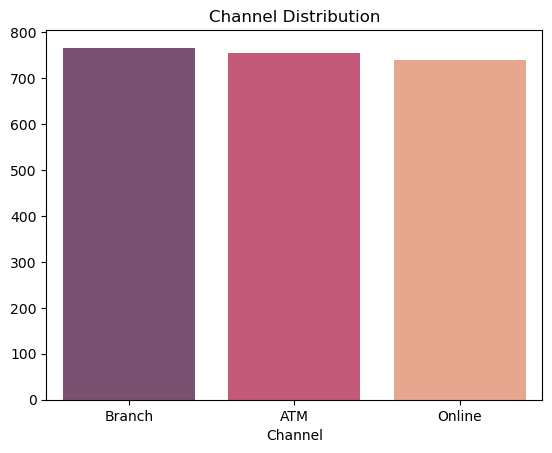

In [24]:
sns.barplot(
    x=df_categorical["Channel"].value_counts().index,
    y=df_categorical["Channel"].value_counts().values,
    palette="rocket",
    alpha=0.8
)
plt.title("Channel Distribution")
plt.show()

/tmp/ipykernel_13449/811159641.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


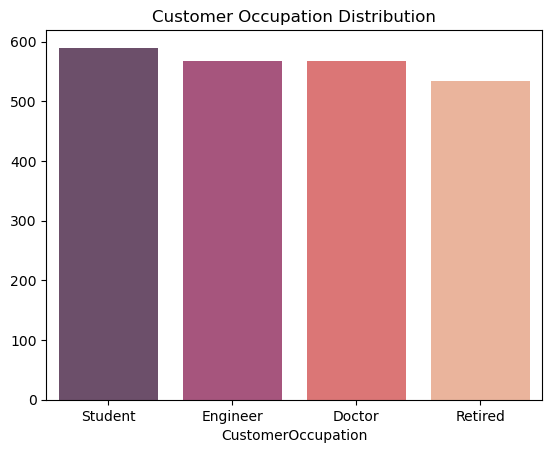

In [25]:
sns.barplot(
    x=df_categorical["CustomerOccupation"].value_counts().index,
    y=df_categorical["CustomerOccupation"].value_counts().values,
    palette="rocket",
    alpha=0.8
)
plt.title("Customer Occupation Distribution")
plt.show()

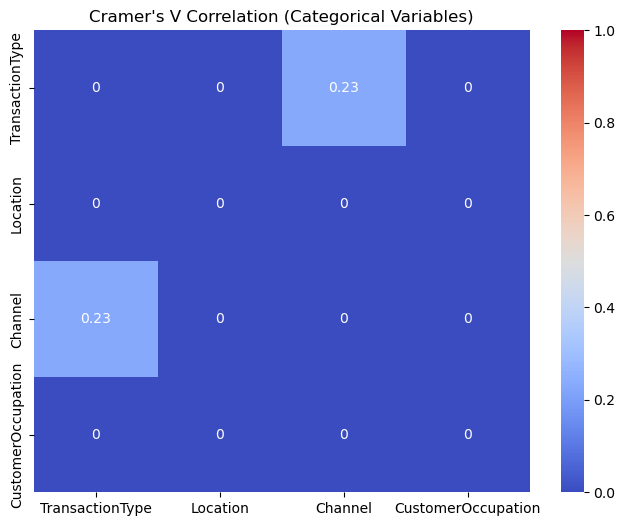

In [31]:
# === 1. Fungsi untuk hitung Cramer's V ===
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# === 2. Kolom kategorikal ===
cat_cols = ["TransactionType", "Location", "Channel", "CustomerOccupation"]

# === 3. Buat matrix kosong ===
matrix = pd.DataFrame(np.zeros((len(cat_cols), len(cat_cols))), 
                      index=cat_cols, columns=cat_cols)

# === 4. Hitung Cramer's V untuk setiap pasangan kolom ===
for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 != col2:
            matrix.loc[col1, col2] = cramers_v(df_categorical[col1], df_categorical[col2])

# === 5. Visualisasi heatmap ===
plt.figure(figsize=(8,6))
sns.heatmap(matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Cramer's V Correlation (Categorical Variables)")
plt.show()


---

### 🔎 Hasil yang di dapat

* Heatmap ukuran **5x5** dengan nilai **0–1**.
* Nilai mendekati **0 → tidak ada hubungan**.
* Nilai mendekati **1 → hubungan sangat kuat**.

---


# **4. Membangun Model Klasifikasi**
Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Menggunakan algoritma klasifikasi yaitu Decision Tree.
2. Latih model menggunakan data yang sudah dipisah.

In [ ]:
# Buatlah model klasifikasi menggunakan Decision Tree

In [ ]:
# Menyimpan Model
# import joblib
# joblib.dump(model, 'decision_tree_model.h5')

# **5. Memenuhi Kriteria Skilled dan Advanced dalam Membangun Model Klasifikasi**



**Biarkan kosong jika tidak menerapkan kriteria skilled atau advanced**

In [ ]:
# Melatih model menggunakan algoritma klasifikasi scikit-learn selain Decision Tree.

In [ ]:
# Menampilkan hasil evaluasi akurasi, presisi, recall, dan F1-Score pada seluruh algoritma yang sudah dibuat.

In [ ]:
# Menyimpan Model Selain Decision Tree
# Model ini bisa lebih dari satu
# import joblib
# joblib.dump(___, 'explore_<Nama Algoritma>_classification.h5')

Hyperparameter Tuning Model

Pilih salah satu algoritma yang ingin Anda tuning

In [ ]:
# Lakukan Hyperparameter Tuning dan Latih ulang.
# Lakukan dalam satu cell ini saja.

In [ ]:
# Menampilkan hasil evaluasi akurasi, presisi, recall, dan F1-Score pada algoritma yang sudah dituning.

In [ ]:
# Menyimpan Model hasil tuning
# import joblib
# joblib.dump(__, 'tuning_classification.h5')

End of Code